In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config
import statsmodels.api as sm
set_config(working_memory=1024)

In [3]:
data = pd.read_csv('tlacuachitos_vip_customers_data.csv')
data.head()

,CustomerID,Age,Income,Tenure,Education,Industry,Geographic Location,Churn_Risk,Cohort
0,1,56,52752.677346,3,Master,Technology,Europe,1,2023-08-31
1,2,69,55297.364348,6,Bachelor,Technology,South America,0,2021-08-31
2,3,46,57978.753383,3,Bachelor,Finance,Europe,1,2019-05-31
3,4,32,60445.266900,3,High School,Education,South America,1,2021-02-28
4,5,60,57741.870929,5,Bachelor,Entertainment,Asia,0,2018-10-31


In [4]:
df_transactions = pd.read_csv('tlacuachitos_vip_transactions.csv')
df_transactions.head()

,CustomerID,TransactionDate,TransactionAmount
0,1,2023-10-31,518.444092
1,1,2024-07-31,353.796197
2,1,2024-01-31,38.206591
3,1,2024-06-30,724.929423
4,2,2022-02-28,145.616000


In [5]:
# Separar variables numéricas y categóricas
numerical_features = ['Age', 'Income', 'Tenure']
categorical_features = ['Education', 'Industry', 'Geographic Location']

# Hacer las categóricas dummies
encoded_features = pd.get_dummies(data[categorical_features], 
               columns=categorical_features, 
               drop_first=True)

# Estandarizar variables numéricas
data_to_model_standarized = StandardScaler().fit_transform(data[numerical_features])

# Hacer dataframe variables numéricas
data_to_model_df = pd.DataFrame(data_to_model_standarized, 
                                columns=numerical_features).reset_index()

# Acomodar variables categóricas
encoded_features_df = encoded_features.reset_index()

# Juntar ambas variables
data_to_model = data_to_model_df.merge(encoded_features_df, on='index')
data_to_model = data_to_model.drop('index', axis=1)

In [6]:
# Dar más peso a ciertas variables para la agrupación
#data_to_model['Income'] = data_to_model['Income'] * 1.2
data_to_model

,Age,Income,Tenure,Education_High School,Education_Master,Education_PhD,Industry_Entertainment,Industry_Finance,Industry_Healthcare,Industry_Technology,Geographic Location_Australia,Geographic Location_Europe,Geographic Location_North America,Geographic Location_South America
0,0.824019,0.121621,-0.878889,False,True,False,False,False,False,True,False,True,False,False
1,1.688471,0.286515,0.451668,False,False,False,False,False,False,True,False,False,False,True
2,0.159056,0.460267,-0.878889,False,False,False,False,True,False,False,False,True,False,False
3,-0.771892,0.620095,-0.878889,True,False,False,False,False,False,False,False,False,False,True
4,1.090004,0.444917,0.008149,False,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,-1.170870,-0.365427,1.338705,False,False,False,False,False,False,False,False,True,False,False
1139,0.491537,-0.713290,1.782224,False,False,False,False,False,False,False,False,False,False,False
1140,-0.971381,0.399656,0.008149,True,False,False,False,True,False,False,False,False,True,False
1141,0.558034,-1.035115,0.451668,False,False,False,False,False,True,False,False,False,True,False


In [7]:
columns_from_education = data_to_model.loc[:, 'Education_High School':].select_dtypes(include='bool').columns
data_to_model[columns_from_education] = data_to_model[columns_from_education].astype(int)
data_to_model

,Age,Income,Tenure,Education_High School,Education_Master,Education_PhD,Industry_Entertainment,Industry_Finance,Industry_Healthcare,Industry_Technology,Geographic Location_Australia,Geographic Location_Europe,Geographic Location_North America,Geographic Location_South America
0,0.824019,0.121621,-0.878889,0,1,0,0,0,0,1,0,1,0,0
1,1.688471,0.286515,0.451668,0,0,0,0,0,0,1,0,0,0,1
2,0.159056,0.460267,-0.878889,0,0,0,0,1,0,0,0,1,0,0
3,-0.771892,0.620095,-0.878889,1,0,0,0,0,0,0,0,0,0,1
4,1.090004,0.444917,0.008149,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,-1.170870,-0.365427,1.338705,0,0,0,0,0,0,0,0,1,0,0
1139,0.491537,-0.713290,1.782224,0,0,0,0,0,0,0,0,0,0,0
1140,-0.971381,0.399656,0.008149,1,0,0,0,1,0,0,0,0,1,0
1141,0.558034,-1.035115,0.451668,0,0,0,0,0,1,0,0,0,1,0


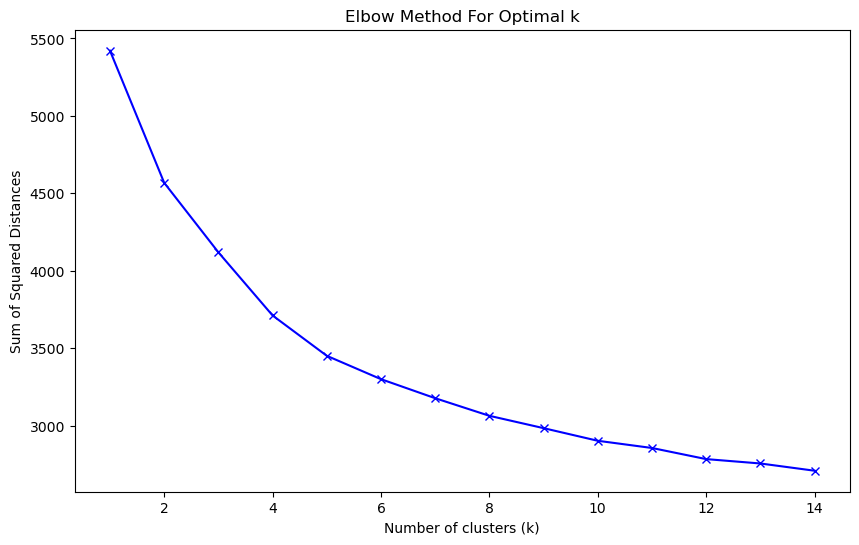

In [8]:
# Determinar el número óptimo de clusters usando el método del codo
sum_of_squared_distances = []
K = range(1, 15)  # Ajuste el rango según sea necesario
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km = km.fit(data_to_model)
    sum_of_squared_distances.append(km.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [9]:
# Aplicar K-means clustering para identificar segmentos de clientes
kmeans = KMeans(n_clusters=5, random_state=42) 
labels = kmeans.fit_predict(data_to_model)

# Agregar las etiquetas del cluster al DataFrame original para análisis
data_to_model['Cluster'] = labels
data['Cluster'] = labels
data.head()

,CustomerID,Age,Income,Tenure,Education,Industry,Geographic Location,Churn_Risk,Cohort,Cluster
0,1,56,52752.677346,3,Master,Technology,Europe,1,2023-08-31,4
1,2,69,55297.364348,6,Bachelor,Technology,South America,0,2021-08-31,4
2,3,46,57978.753383,3,Bachelor,Finance,Europe,1,2019-05-31,4
3,4,32,60445.266900,3,High School,Education,South America,1,2021-02-28,0
4,5,60,57741.870929,5,Bachelor,Entertainment,Asia,0,2018-10-31,4


In [10]:
def boxplot_clusters(columns):
    for col in columns:
        plt.figure(figsize=(5, 5))
        sns.boxplot(x='Cluster', y=col, data=data, hue='Cluster', palette='Set3')
        plt.title(f'Boxplot de {col} por Clusters')
        plt.show()

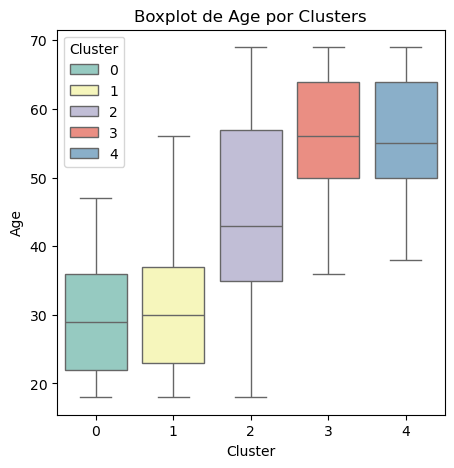

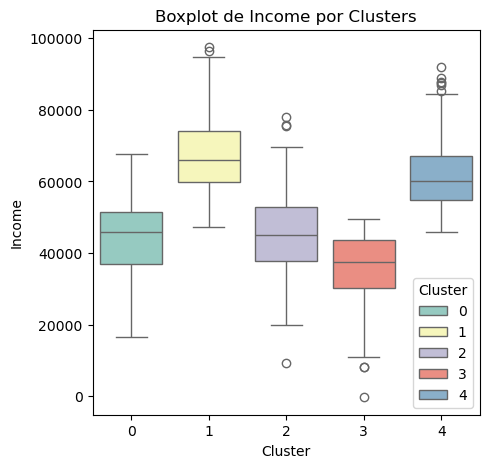

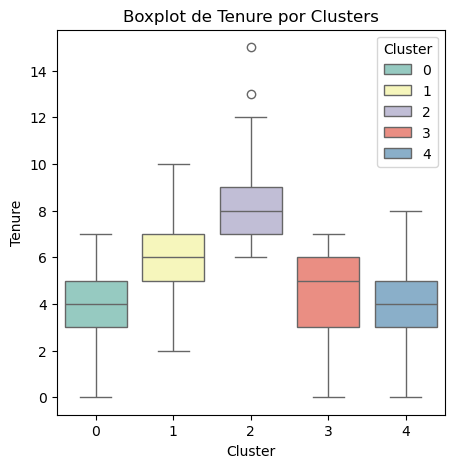

In [11]:
boxplot_clusters(numerical_features)

In [12]:
def barplot_clusters(columns):
    for col in columns:
        sns.countplot(x='Cluster', hue=col, data=data, palette='Set1')
        plt.title('Count of Entries by Cluster')
        plt.xlabel('Cluster')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

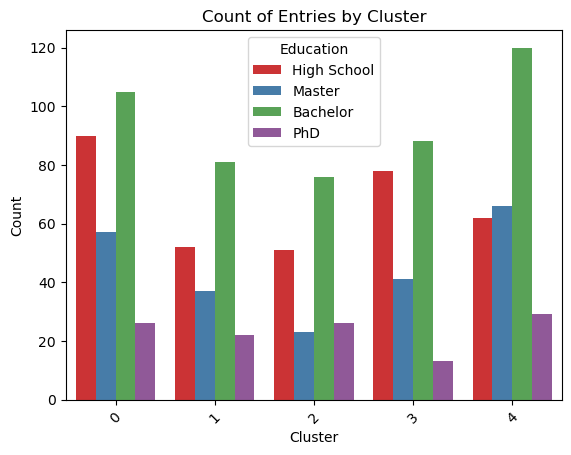

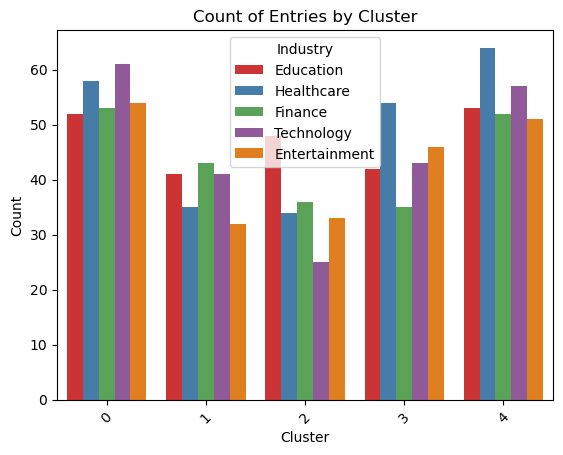

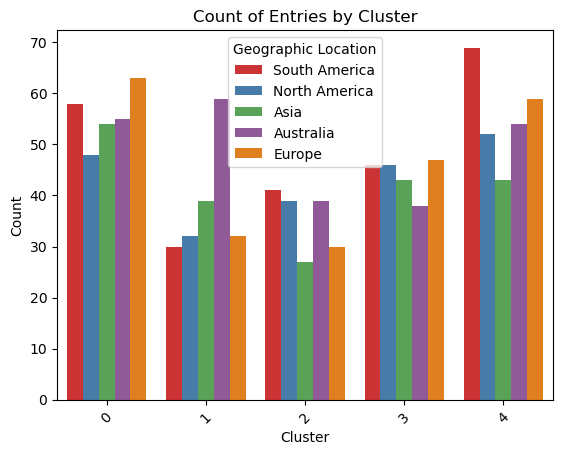

In [13]:
barplot_clusters(categorical_features)

In [14]:
def mean_clusters(columns):
    for col in columns:
        # Calcular la proporción de cada categoría dentro de cada Cluster
        data_grouped = data.groupby(['Cluster', col]).size().reset_index(name='Count')
        # Calcular la proporción
        data_grouped['Proportion'] = data_grouped['Count'] / data_grouped.groupby('Cluster')['Count'].transform('sum')

        plt.figure(figsize=(6, 4))
        sns.barplot(x='Cluster', y='Proportion', hue=col, data=data_grouped, palette='Set1')
        plt.title(f'Proportion of {col} by Cluster')
        plt.xlabel('Cluster')
        plt.ylabel(f'Proportion of {col}')
        plt.xticks(rotation=45)
        plt.legend(title=col)
        plt.show()



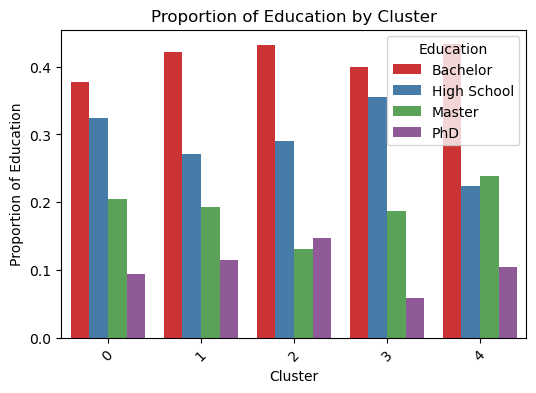

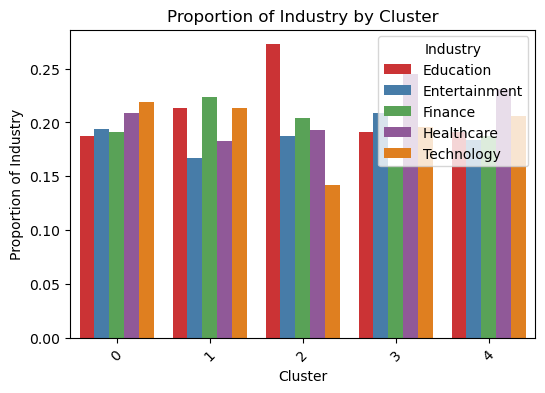

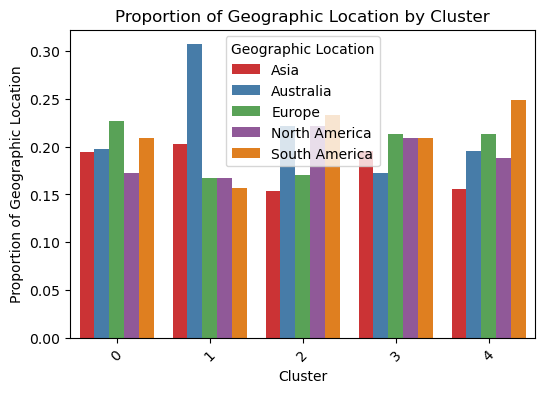

In [15]:
mean_clusters(categorical_features)

## Churn por Cluster

In [17]:
df_transactions.head()

,CustomerID,TransactionDate,TransactionAmount
0,1,2023-10-31,518.444092
1,1,2024-07-31,353.796197
2,1,2024-01-31,38.206591
3,1,2024-06-30,724.929423
4,2,2022-02-28,145.616000


In [18]:
data.head()

,CustomerID,Age,Income,Tenure,Education,Industry,Geographic Location,Churn_Risk,Cohort,Cluster
0,1,56,52752.677346,3,Master,Technology,Europe,1,2023-08-31,4
1,2,69,55297.364348,6,Bachelor,Technology,South America,0,2021-08-31,4
2,3,46,57978.753383,3,Bachelor,Finance,Europe,1,2019-05-31,4
3,4,32,60445.266900,3,High School,Education,South America,1,2021-02-28,0
4,5,60,57741.870929,5,Bachelor,Entertainment,Asia,0,2018-10-31,4


In [19]:
X = df_transactions.merge(data, on = 'CustomerID')
X.head()

,CustomerID,TransactionDate,TransactionAmount,Age,Income,Tenure,Education,Industry,Geographic Location,Churn_Risk,Cohort,Cluster
0,1,2023-10-31,518.444092,56,52752.677346,3,Master,Technology,Europe,1,2023-08-31,4
1,1,2024-07-31,353.796197,56,52752.677346,3,Master,Technology,Europe,1,2023-08-31,4
2,1,2024-01-31,38.206591,56,52752.677346,3,Master,Technology,Europe,1,2023-08-31,4
3,1,2024-06-30,724.929423,56,52752.677346,3,Master,Technology,Europe,1,2023-08-31,4
4,2,2022-02-28,145.616000,69,55297.364348,6,Bachelor,Technology,South America,0,2021-08-31,4


In [20]:
X['TransactionDate'] = pd.to_datetime(X['TransactionDate'])

In [21]:
X.sort_values(by=['CustomerID', 'TransactionDate'])
X.head()

,CustomerID,TransactionDate,TransactionAmount,Age,Income,Tenure,Education,Industry,Geographic Location,Churn_Risk,Cohort,Cluster
0,1,2023-10-31,518.444092,56,52752.677346,3,Master,Technology,Europe,1,2023-08-31,4
1,1,2024-07-31,353.796197,56,52752.677346,3,Master,Technology,Europe,1,2023-08-31,4
2,1,2024-01-31,38.206591,56,52752.677346,3,Master,Technology,Europe,1,2023-08-31,4
3,1,2024-06-30,724.929423,56,52752.677346,3,Master,Technology,Europe,1,2023-08-31,4
4,2,2022-02-28,145.616000,69,55297.364348,6,Bachelor,Technology,South America,0,2021-08-31,4


In [22]:
customer_invoices = X.groupby(['Cluster', 'CustomerID', 'TransactionDate'])['TransactionAmount'].sum().reset_index()
customer_invoices.head()

,Cluster,CustomerID,TransactionDate,TransactionAmount
0,0,4,2021-02-28,350.545374
1,0,4,2021-06-28,42.259824
2,0,4,2021-07-28,22.300978
3,0,4,2021-11-28,322.891563
4,0,4,2023-01-28,357.028148


In [23]:
sum(customer_invoices['TransactionAmount'] < 0)

0

In [24]:
customer_invoices_clean = customer_invoices[customer_invoices['TransactionAmount'] > 0].copy().dropna()

In [25]:
snapshot_date = customer_invoices_clean['TransactionDate'].max() 
snapshot_date

Timestamp('2024-08-31 00:00:00')

In [26]:
# Calculate days between purchases
customer_invoices_clean['DaysBetweenPurchases'] = customer_invoices_clean.groupby(['Cluster', 'CustomerID'])['TransactionDate'].diff().dt.days
customer_invoices_clean.head()

,Cluster,CustomerID,TransactionDate,TransactionAmount,DaysBetweenPurchases
0,0,4,2021-02-28,350.545374,NaN
1,0,4,2021-06-28,42.259824,120.0
2,0,4,2021-07-28,22.300978,30.0
3,0,4,2021-11-28,322.891563,123.0
4,0,4,2023-01-28,357.028148,426.0


In [27]:
general_threshold = customer_invoices_clean['DaysBetweenPurchases'].quantile(0.90)
general_threshold

426.0

In [28]:
threshold_per_country = customer_invoices_clean.groupby('Cluster')['DaysBetweenPurchases'].agg(
    percentile_90=lambda x: x.quantile(0.90),
    transaction_count='count'
).reset_index()

threshold_per_country.head()

,Cluster,percentile_90,transaction_count
0,0,438.2,627
1,1,427.0,473
2,2,377.2,527
3,3,413.4,555
4,4,456.0,681


In [29]:
threshold_per_country['threshold'] = threshold_per_country.apply(
    lambda row: general_threshold if row['transaction_count'] < 30 else row['percentile_90'],
    axis=1
)

threshold_per_country.head()

,Cluster,percentile_90,transaction_count,threshold
0,0,438.2,627,438.2
1,1,427.0,473,427.0
2,2,377.2,527,377.2
3,3,413.4,555,413.4
4,4,456.0,681,456.0


In [30]:
last_invoice_date_per_customer = customer_invoices_clean.groupby(['Cluster','CustomerID'])['TransactionDate'].max().reset_index().rename(columns={'TransactionDate': 'LastTransactionDate'})
last_invoice_date_per_customer.head()

,Cluster,CustomerID,LastTransactionDate
0,0,4,2023-01-28
1,0,6,2024-02-29
2,0,9,2024-07-30
3,0,10,2020-03-31
4,0,12,2024-01-30


In [31]:
customers = last_invoice_date_per_customer.merge(threshold_per_country, on='Cluster')
customers.head()

,Cluster,CustomerID,LastTransactionDate,percentile_90,transaction_count,threshold
0,0,4,2023-01-28,438.2,627,438.2
1,0,6,2024-02-29,438.2,627,438.2
2,0,9,2024-07-30,438.2,627,438.2
3,0,10,2020-03-31,438.2,627,438.2
4,0,12,2024-01-30,438.2,627,438.2


In [32]:
customers['inactivity_days'] = (snapshot_date - customers['LastTransactionDate']).dt.days
customers['churned'] = (customers['inactivity_days'] > customers['threshold']).astype('int')

customers.head()

,Cluster,CustomerID,LastTransactionDate,percentile_90,transaction_count,threshold,inactivity_days,churned
0,0,4,2023-01-28,438.2,627,438.2,581,1
1,0,6,2024-02-29,438.2,627,438.2,184,0
2,0,9,2024-07-30,438.2,627,438.2,32,0
3,0,10,2020-03-31,438.2,627,438.2,1614,1
4,0,12,2024-01-30,438.2,627,438.2,214,0


<Axes: xlabel='Cluster'>

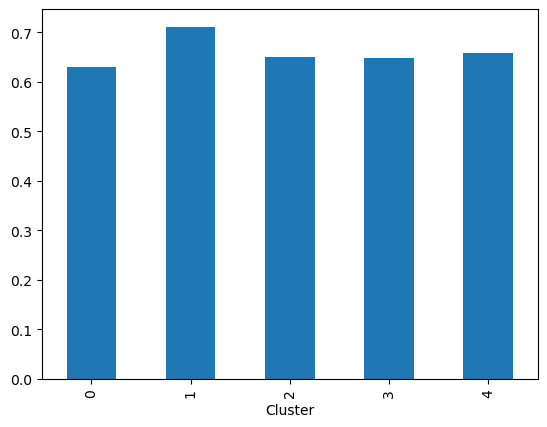

In [33]:
customers.groupby('Cluster')['churned'].mean().plot(kind='bar')

## Regresión (Filtro 2 años)

In [35]:
df_transactions['TransactionDate'] = pd.to_datetime(df_transactions['TransactionDate'])

In [36]:
data['Cohort'] = pd.to_datetime(data['Cohort'])

In [37]:
snapshot_date = df_transactions['TransactionDate'].max()

In [38]:
data['customer_tenure'] = (snapshot_date.year - data['Cohort'].dt.year) * 12 + (
    snapshot_date.month - data['Cohort'].dt.month)
data['customer_tenure']

0       12
1       36
2       63
3       42
4       70
        ..
1138    56
1139    22
1140    76
1141    70
1142    17
Name: customer_tenure, Length: 1143, dtype: int32

In [39]:
df_master = df_transactions.merge(data, on = 'CustomerID')
df_master.head()

,CustomerID,TransactionDate,TransactionAmount,Age,Income,Tenure,Education,Industry,Geographic Location,Churn_Risk,Cohort,Cluster,customer_tenure
0,1,2023-10-31,518.444092,56,52752.677346,3,Master,Technology,Europe,1,2023-08-31,4,12
1,1,2024-07-31,353.796197,56,52752.677346,3,Master,Technology,Europe,1,2023-08-31,4,12
2,1,2024-01-31,38.206591,56,52752.677346,3,Master,Technology,Europe,1,2023-08-31,4,12
3,1,2024-06-30,724.929423,56,52752.677346,3,Master,Technology,Europe,1,2023-08-31,4,12
4,2,2022-02-28,145.616000,69,55297.364348,6,Bachelor,Technology,South America,0,2021-08-31,4,36


In [40]:
df_master['customer_tenure_on_transaction'] = (df_master['TransactionDate'].dt.year - df_master['Cohort'].dt.year)*12 + (
    df_master['TransactionDate'].dt.month - df_master['Cohort'].dt.month)
df_master.head()

,CustomerID,TransactionDate,TransactionAmount,Age,Income,Tenure,Education,Industry,Geographic Location,Churn_Risk,Cohort,Cluster,customer_tenure,customer_tenure_on_transaction
0,1,2023-10-31,518.444092,56,52752.677346,3,Master,Technology,Europe,1,2023-08-31,4,12,2
1,1,2024-07-31,353.796197,56,52752.677346,3,Master,Technology,Europe,1,2023-08-31,4,12,11
2,1,2024-01-31,38.206591,56,52752.677346,3,Master,Technology,Europe,1,2023-08-31,4,12,5
3,1,2024-06-30,724.929423,56,52752.677346,3,Master,Technology,Europe,1,2023-08-31,4,12,10
4,2,2022-02-28,145.616000,69,55297.364348,6,Bachelor,Technology,South America,0,2021-08-31,4,36,6


In [41]:
cltv_24_months = df_master.query(
    "customer_tenure > 24 and customer_tenure_on_transaction <= 24").groupby(
    'CustomerID')['TransactionAmount'].sum().reset_index()
cltv_24_months

,CustomerID,TransactionAmount
0,2,145.616000
1,3,487.285458
2,4,1095.025887
3,5,1685.260152
4,6,728.364381
...,...,...
857,1136,189.961932
858,1138,2375.255820
859,1139,1327.509070
860,1141,718.548745


In [42]:
categorical_features = ['Education','Industry','Geographic Location']
numerical_features = ['Age','Income','Tenure']

data_encoded = pd.get_dummies(data[['CustomerID'] + categorical_features], columns=categorical_features, drop_first=True)


df_data_with_encoded = data[['CustomerID'] + numerical_features].merge(
    data_encoded, on = 'CustomerID'
)

df_to_model = cltv_24_months.merge(df_data_with_encoded, on = 'CustomerID')
df_to_model

,CustomerID,TransactionAmount,Age,Income,Tenure,Education_High School,Education_Master,Education_PhD,Industry_Entertainment,Industry_Finance,Industry_Healthcare,Industry_Technology,Geographic Location_Australia,Geographic Location_Europe,Geographic Location_North America,Geographic Location_South America
0,2,145.616000,69,55297.364348,6,False,False,False,False,False,False,True,False,False,False,True
1,3,487.285458,46,57978.753383,3,False,False,False,False,True,False,False,False,True,False,False
2,4,1095.025887,32,60445.266900,3,True,False,False,False,False,False,False,False,False,False,True
3,5,1685.260152,60,57741.870929,5,False,False,False,True,False,False,False,False,False,False,False
4,6,728.364381,25,57132.404622,3,False,True,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,1136,189.961932,67,59279.959062,4,True,False,False,False,True,False,False,False,False,False,False
858,1138,2375.255820,28,59996.754751,5,False,False,False,True,False,False,False,False,False,True,False
859,1139,1327.509070,26,45236.402018,8,False,False,False,False,False,False,False,False,True,False,False
860,1141,718.548745,29,57043.387540,5,True,False,False,False,True,False,False,False,False,True,False


In [43]:
columns_from_education = df_to_model.loc[:, 'Education_High School':].select_dtypes(include='bool').columns
df_to_model[columns_from_education] = df_to_model[columns_from_education].astype(int)
df_to_model.head()

,CustomerID,TransactionAmount,Age,Income,Tenure,Education_High School,Education_Master,Education_PhD,Industry_Entertainment,Industry_Finance,Industry_Healthcare,Industry_Technology,Geographic Location_Australia,Geographic Location_Europe,Geographic Location_North America,Geographic Location_South America
0,2,145.616000,69,55297.364348,6,0,0,0,0,0,0,1,0,0,0,1
1,3,487.285458,46,57978.753383,3,0,0,0,0,1,0,0,0,1,0,0
2,4,1095.025887,32,60445.266900,3,1,0,0,0,0,0,0,0,0,0,1
3,5,1685.260152,60,57741.870929,5,0,0,0,1,0,0,0,0,0,0,0
4,6,728.364381,25,57132.404622,3,0,1,0,0,0,1,0,0,0,1,0


In [44]:
X1 = df_to_model[['Age', 'Income','Tenure','Education_High School','Education_Master','Education_PhD','Industry_Entertainment','Industry_Finance',
                 'Industry_Healthcare','Industry_Technology','Geographic Location_Australia','Geographic Location_Europe',
                 'Geographic Location_North America','Geographic Location_South America']]  
y1 = df_to_model['TransactionAmount']  

In [45]:
# Agregar la constante (intercepto) a las variables independientes
X1 = sm.add_constant(X1)

# Ajustar el modelo usando OLS
model_1 = sm.OLS(y1, X1)       
results = model_1.fit()      

# Mostrar el resumen del modelo
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      TransactionAmount   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     8.979
Date:                Tue, 08 Oct 2024   Prob (F-statistic):           1.53e-18
Time:                        14:16:55   Log-Likelihood:                -6767.4
No. Observations:                 862   AIC:                         1.356e+04
Df Residuals:                     847   BIC:                         1.364e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

## Regresión Completa

In [47]:
df_master2 = df_transactions.merge(data, on = 'CustomerID')
df_master2.head()

,CustomerID,TransactionDate,TransactionAmount,Age,Income,Tenure,Education,Industry,Geographic Location,Churn_Risk,Cohort,Cluster,customer_tenure
0,1,2023-10-31,518.444092,56,52752.677346,3,Master,Technology,Europe,1,2023-08-31,4,12
1,1,2024-07-31,353.796197,56,52752.677346,3,Master,Technology,Europe,1,2023-08-31,4,12
2,1,2024-01-31,38.206591,56,52752.677346,3,Master,Technology,Europe,1,2023-08-31,4,12
3,1,2024-06-30,724.929423,56,52752.677346,3,Master,Technology,Europe,1,2023-08-31,4,12
4,2,2022-02-28,145.616000,69,55297.364348,6,Bachelor,Technology,South America,0,2021-08-31,4,36


In [48]:
categorical_features = ['Education','Industry','Geographic Location']
numerical_features = ['Age','Income','Tenure']

data_encoded = pd.get_dummies(df_master2[['CustomerID'] + categorical_features], columns=categorical_features, drop_first=True)


df_data_with_encoded = df_master2[['CustomerID'] + numerical_features].merge(
    data_encoded, on = 'CustomerID'
)

cosa = pd.DataFrame(df_data_with_encoded.groupby('CustomerID')[df_data_with_encoded.columns[1:]].mean())
cosa.head()

,Age,Income,Tenure,Education_High School,Education_Master,Education_PhD,Industry_Entertainment,Industry_Finance,Industry_Healthcare,Industry_Technology,Geographic Location_Australia,Geographic Location_Europe,Geographic Location_North America,Geographic Location_South America
CustomerID,,,,,,,,,,,,,,
1,56.0,52752.677346,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,69.0,55297.364348,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,46.0,57978.753383,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,32.0,60445.266900,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,60.0,57741.870929,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
grouped_transactions = pd.DataFrame(df_transactions.groupby('CustomerID')['TransactionAmount'].sum())
todo = grouped_transactions.merge(cosa, on = 'CustomerID')

In [50]:
X = todo[['Age', 'Income','Tenure','Education_High School','Education_Master','Education_PhD','Industry_Entertainment','Industry_Finance',
                 'Industry_Healthcare','Industry_Technology','Geographic Location_Australia','Geographic Location_Europe',
                 'Geographic Location_North America','Geographic Location_South America']]  
y = todo['TransactionAmount']  

In [51]:
# Agregar la constante (intercepto) a las variables independientes
X = sm.add_constant(X)

# Ajustar el modelo usando OLS
model = sm.OLS(y, X)       
results = model.fit()      

# Mostrar el resumen del modelo
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      TransactionAmount   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     10.91
Date:                Tue, 08 Oct 2024   Prob (F-statistic):           1.29e-23
Time:                        14:16:55   Log-Likelihood:                -8770.2
No. Observations:                1111   AIC:                         1.757e+04
Df Residuals:                    1096   BIC:                         1.765e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 